In [74]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
(ds_train), ds_info = tfds. load (
    "cats_vs_dogs", #it is name that is in catelog of link above
    split=["train"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,

)

ds_train=ds_train[0]

def normalize_image(image, label):
  image=tf.image.resize(image, (256,256))
  return tf.cast(image, tf.float32)/255.0, label

AUTOTUNE=tf.data.experimental.AUTOTUNE #tf allow us to give this to set automatically
BATCH_SIZE=1

ds_train=ds_train.map(normalize_image, num_parallel_calls=AUTOTUNE) # in normalize function these is no sequence so
#process can be done paralelly
ds_train= ds_train.cache() #it keep next data in memory so it will be fast
ds_train=ds_train.shuffle(1000) #we can give 1000 so it will see 1000 datat points but
#it depends on records in a file so take from that
ds_train=ds_train.batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE) #it keeps 64 examples ready when running on gpu the current one



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteWA89X4/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
ds_train=ds_train.take(1000)

In [24]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= 'imagenet',
    input_shape=(256, 256, 3),

)
vgg_backbone.trainable=False

In [5]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [6]:
#now we will output from different layers, we will select only the conv layer

In [7]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [8]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = tf.keras.Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
for im, label in ds_train.take(1):
  print(im.shape, label)

(1, 256, 256, 3) tf.Tensor([1], shape=(1,), dtype=int64)


In [10]:
f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 890ms/step


In [11]:
print(len(f_maps))

13


In [12]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


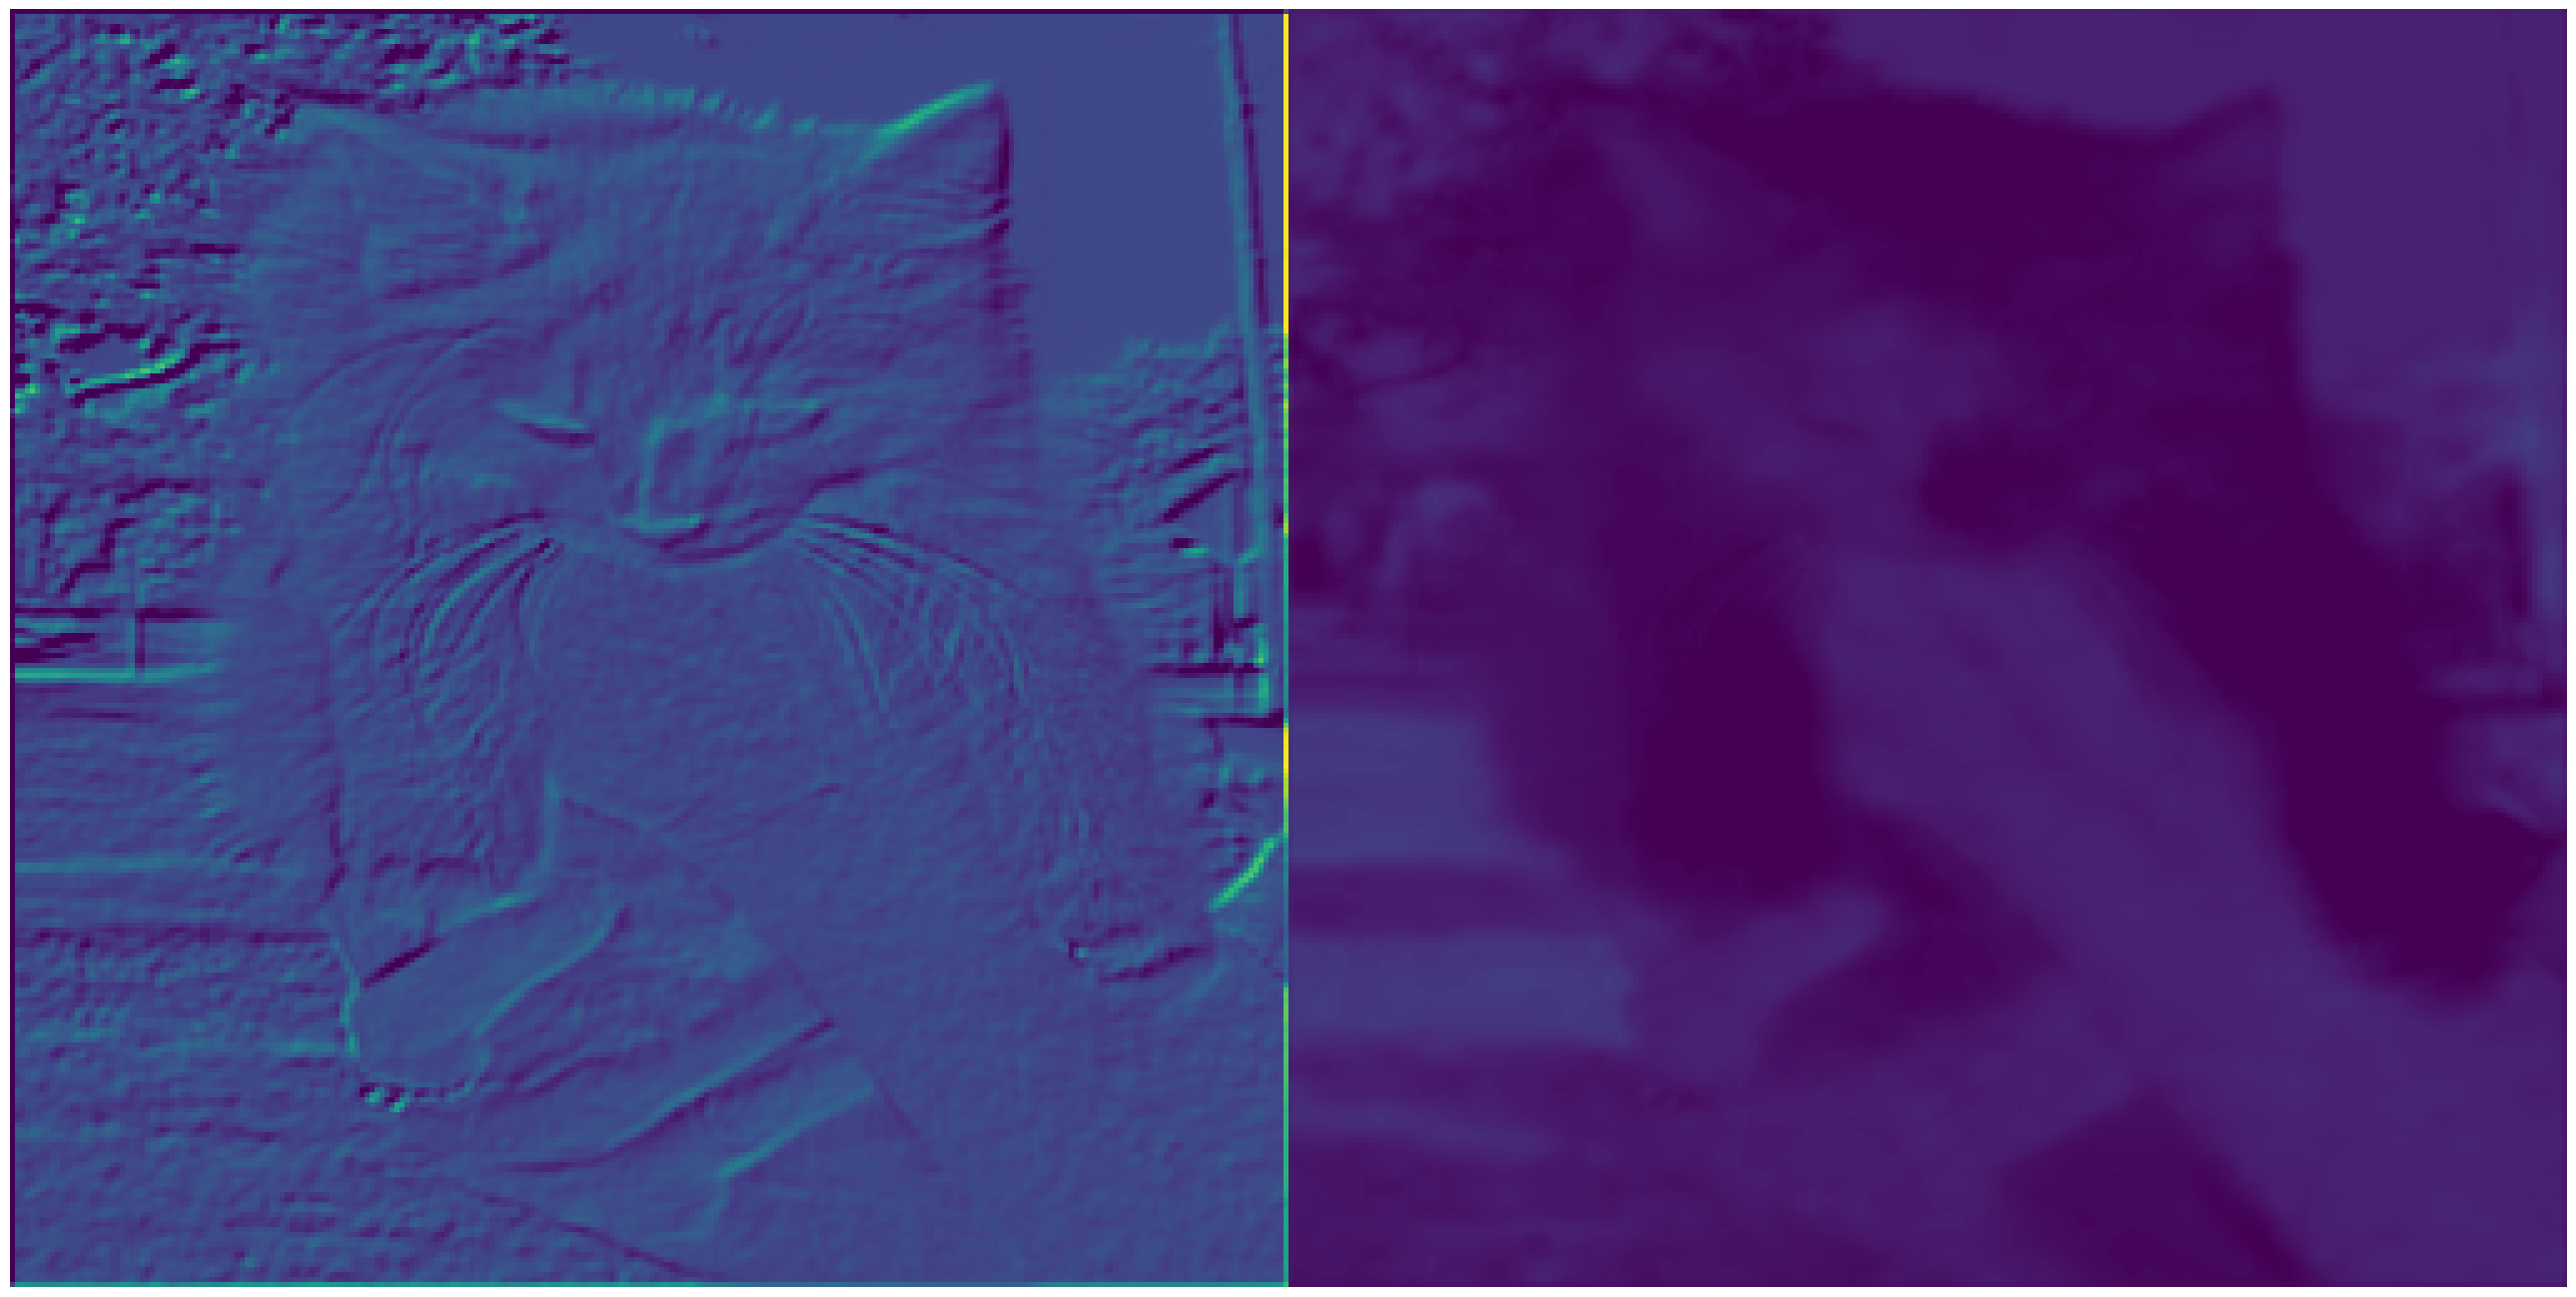

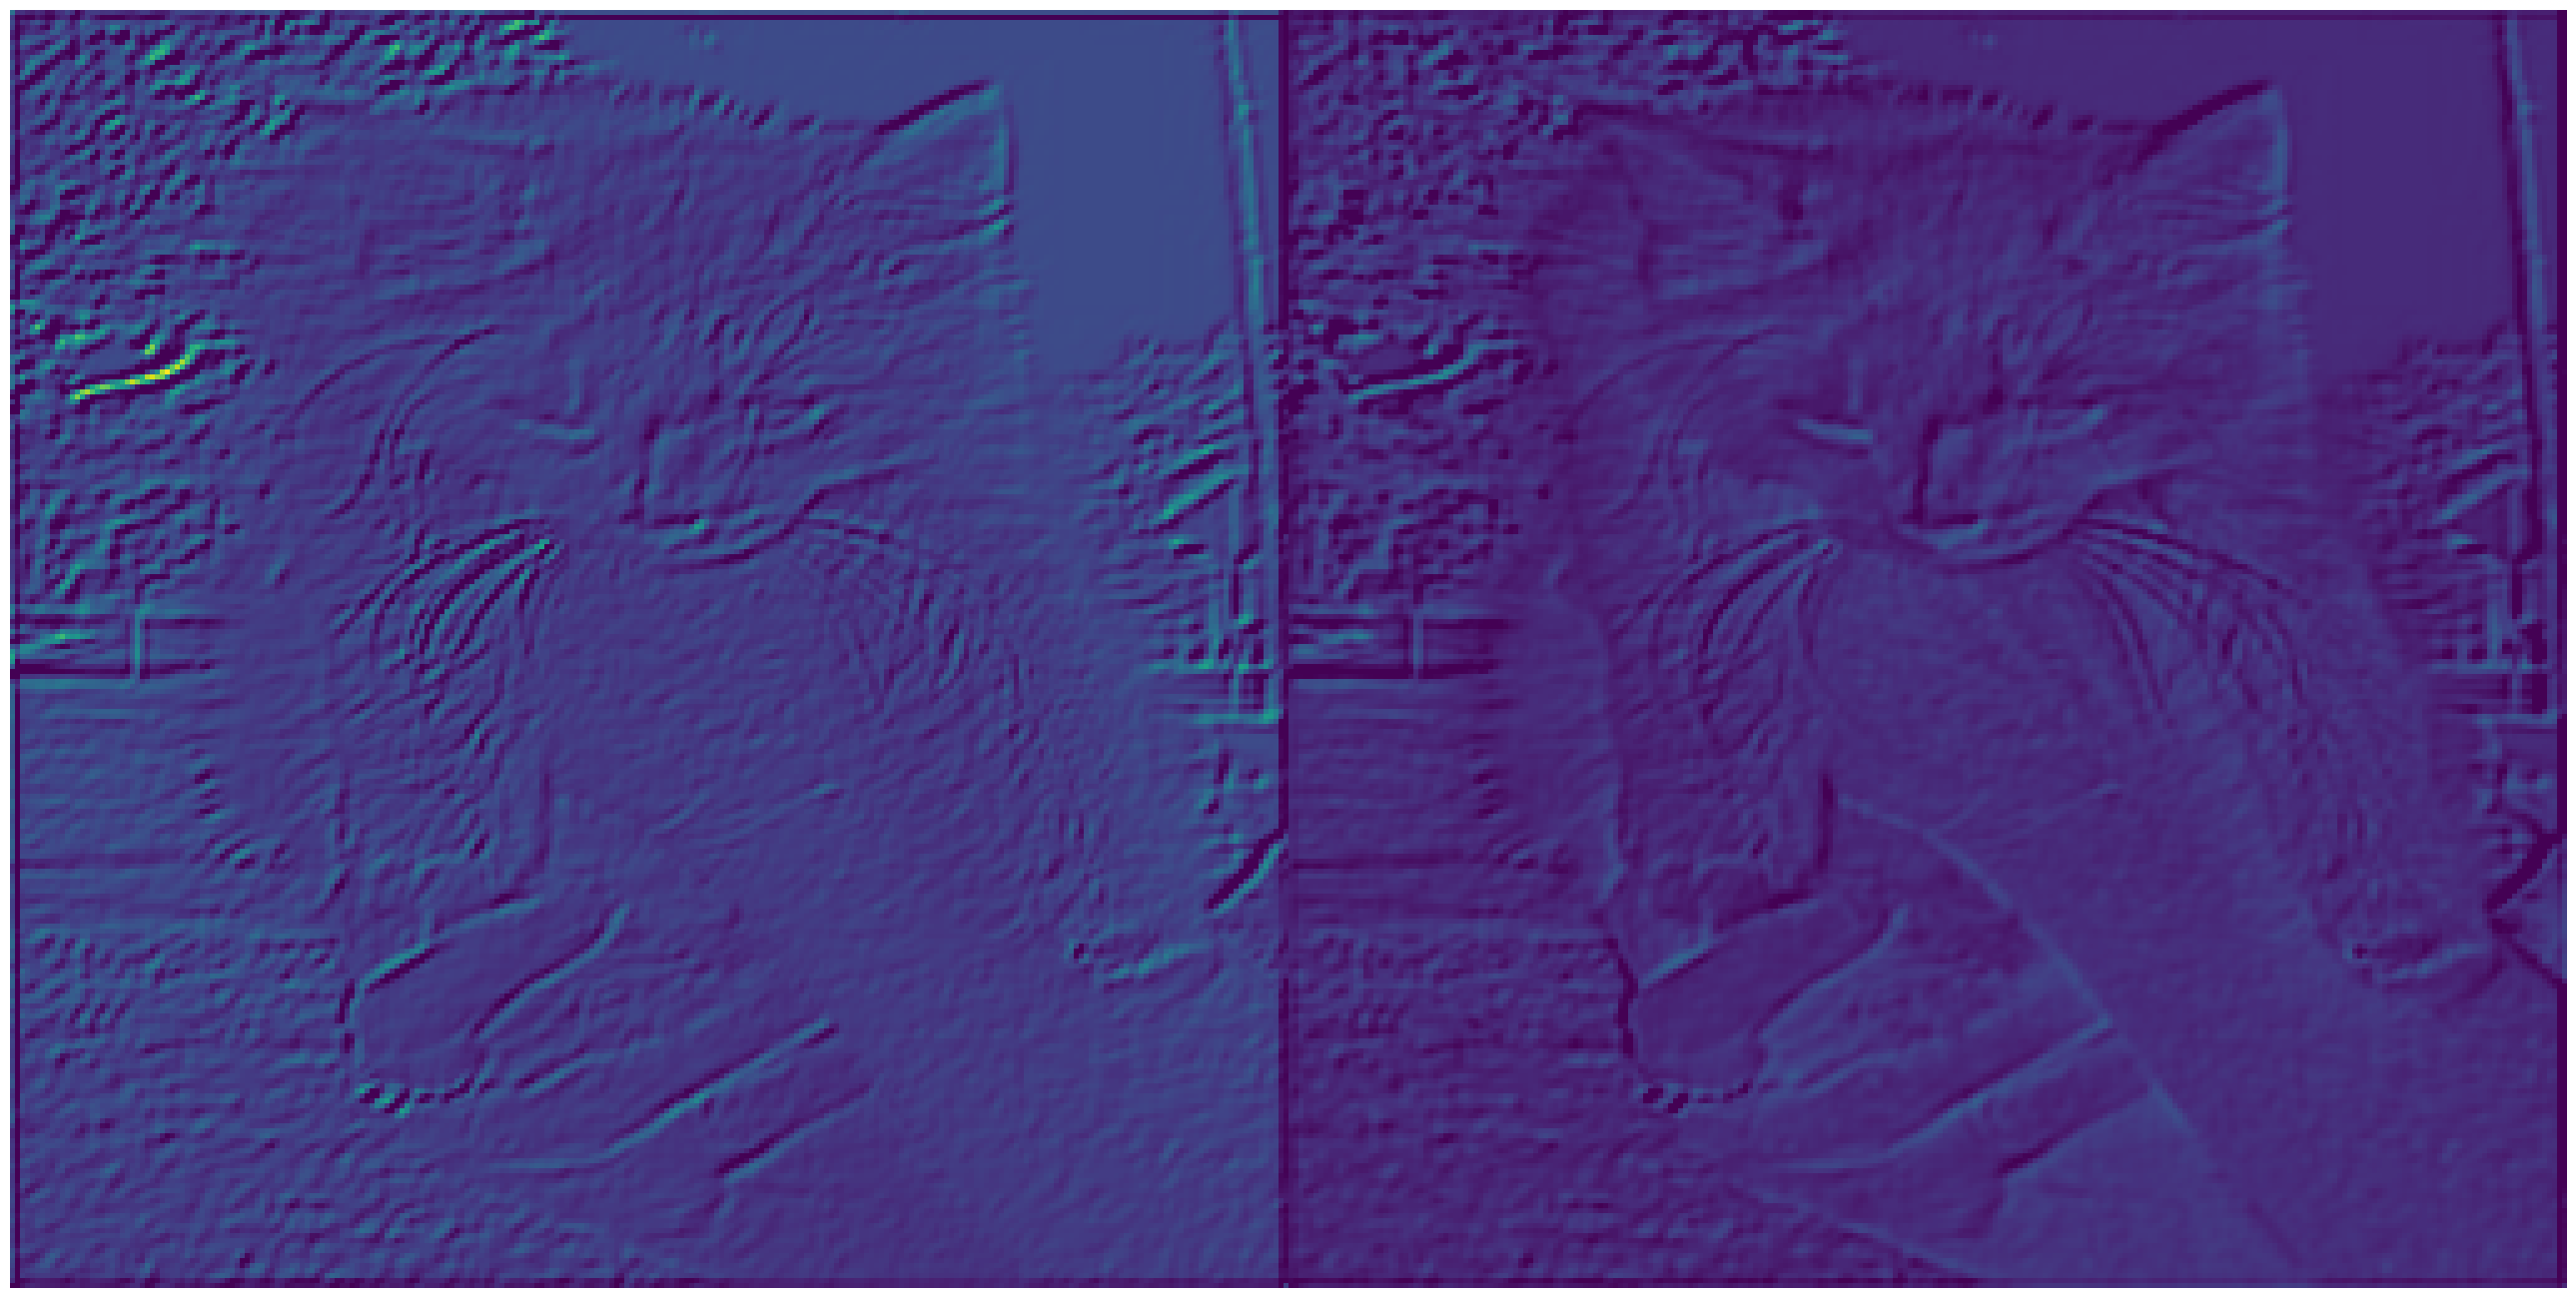

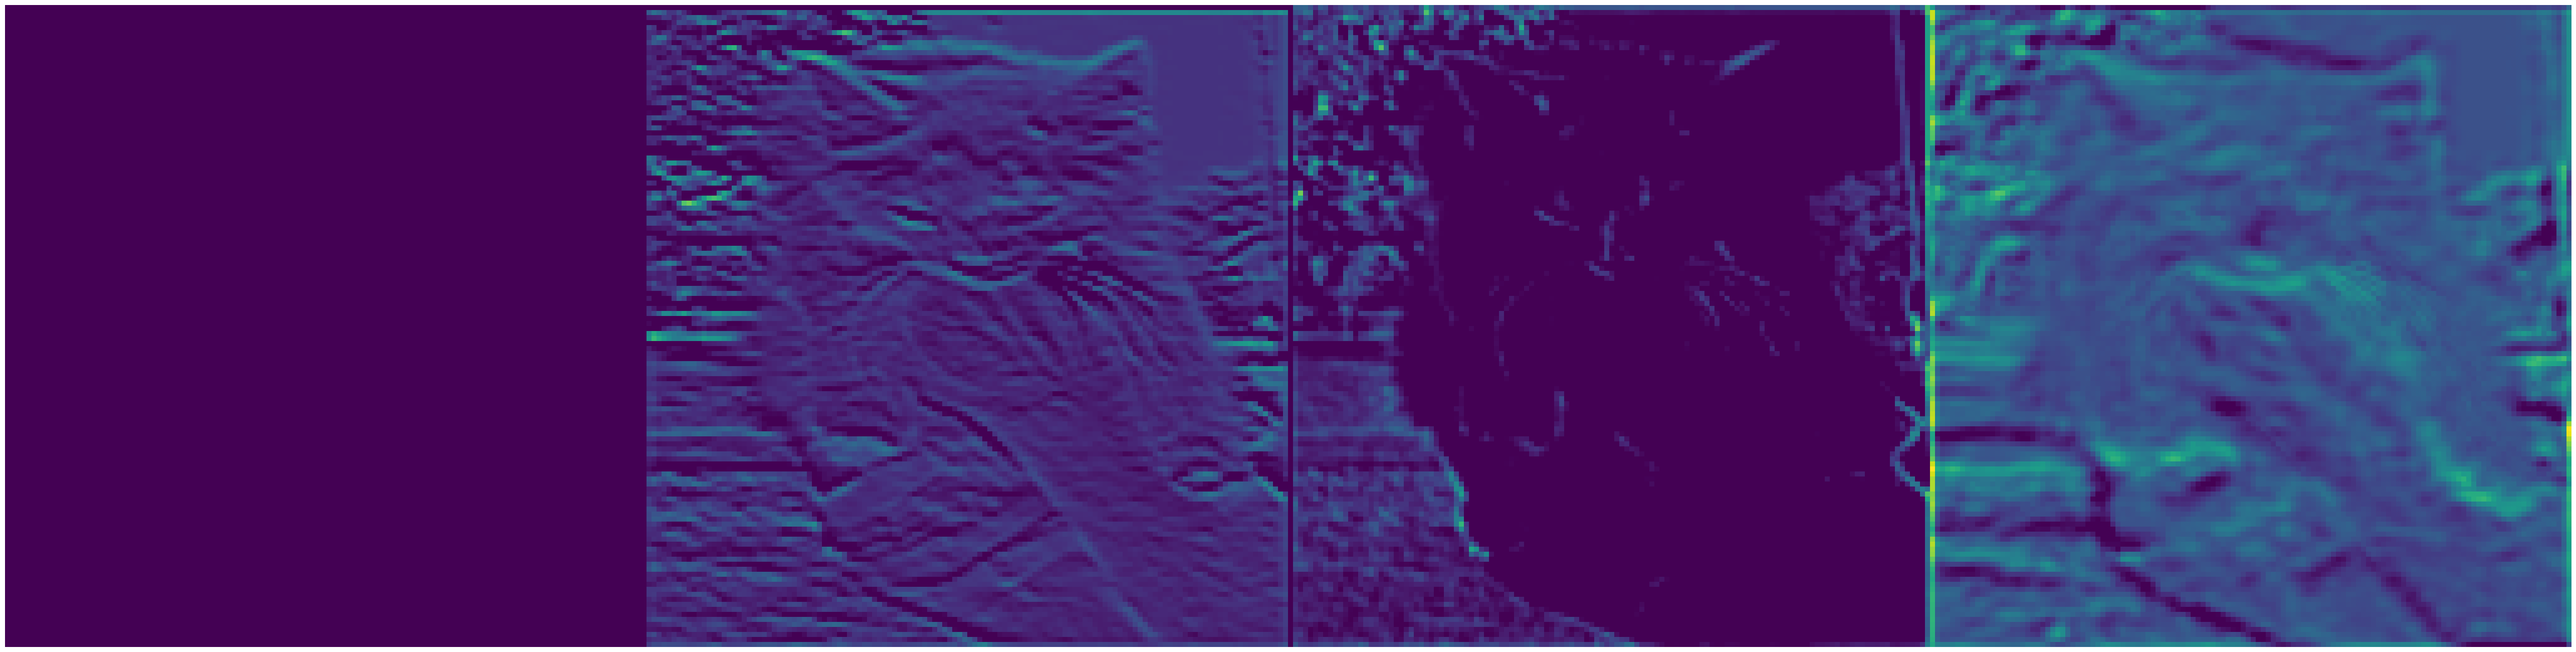

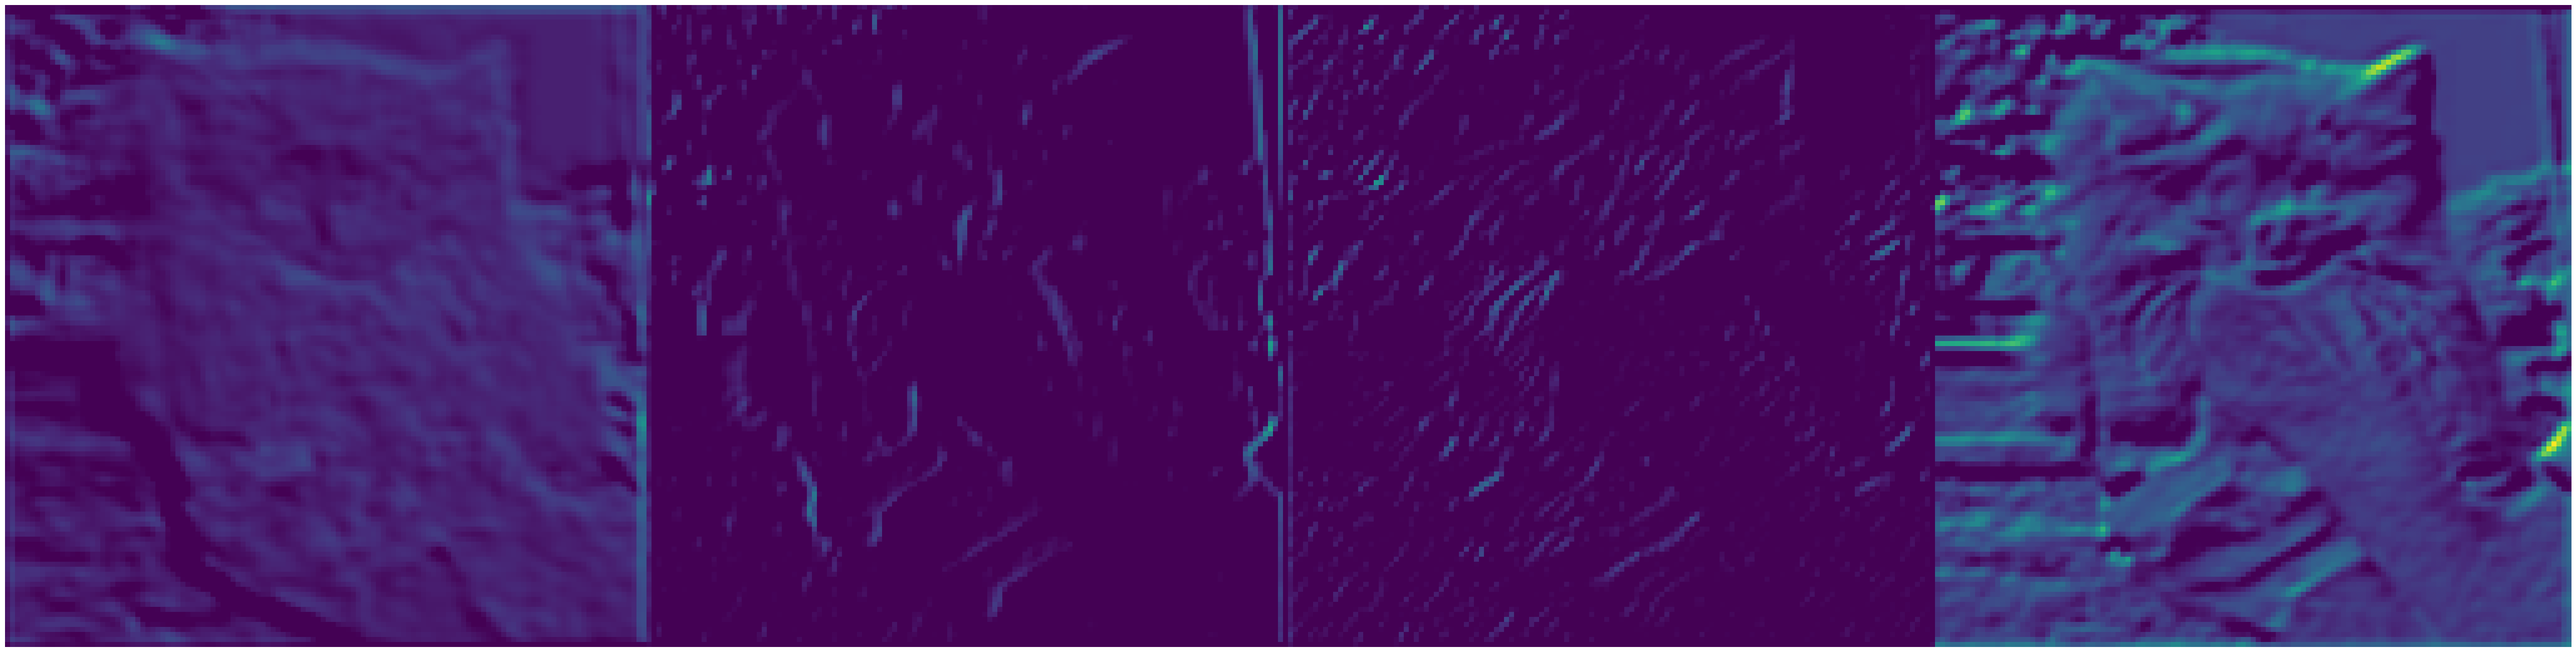

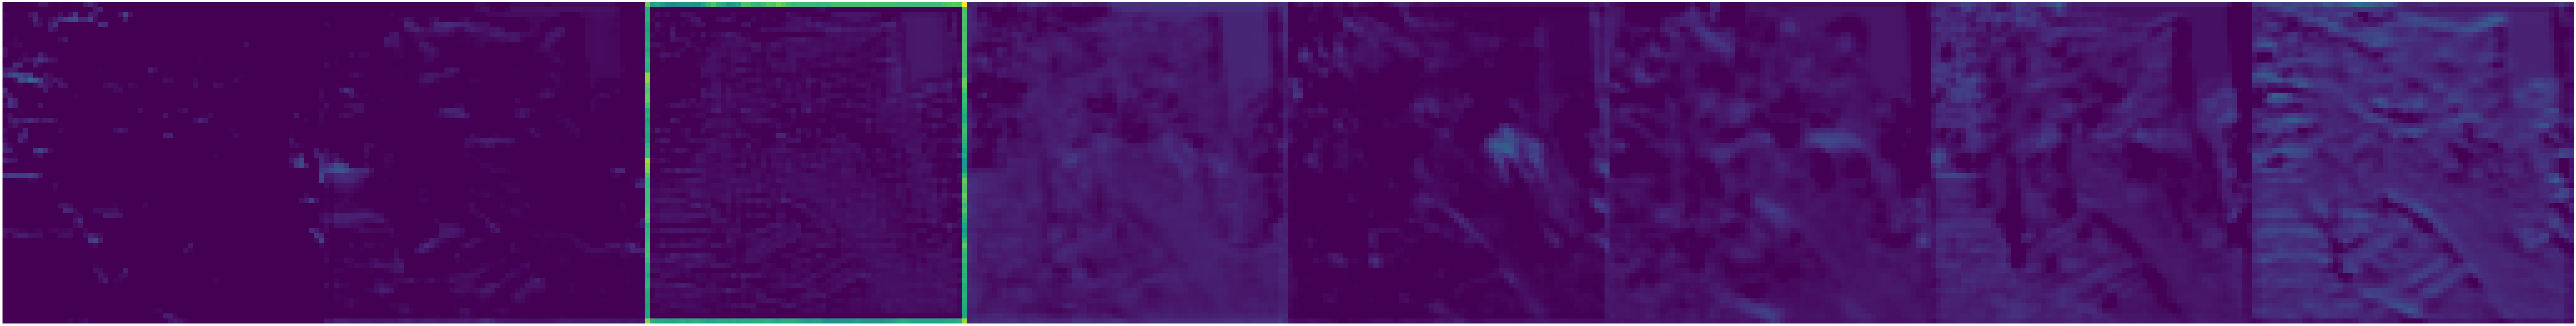

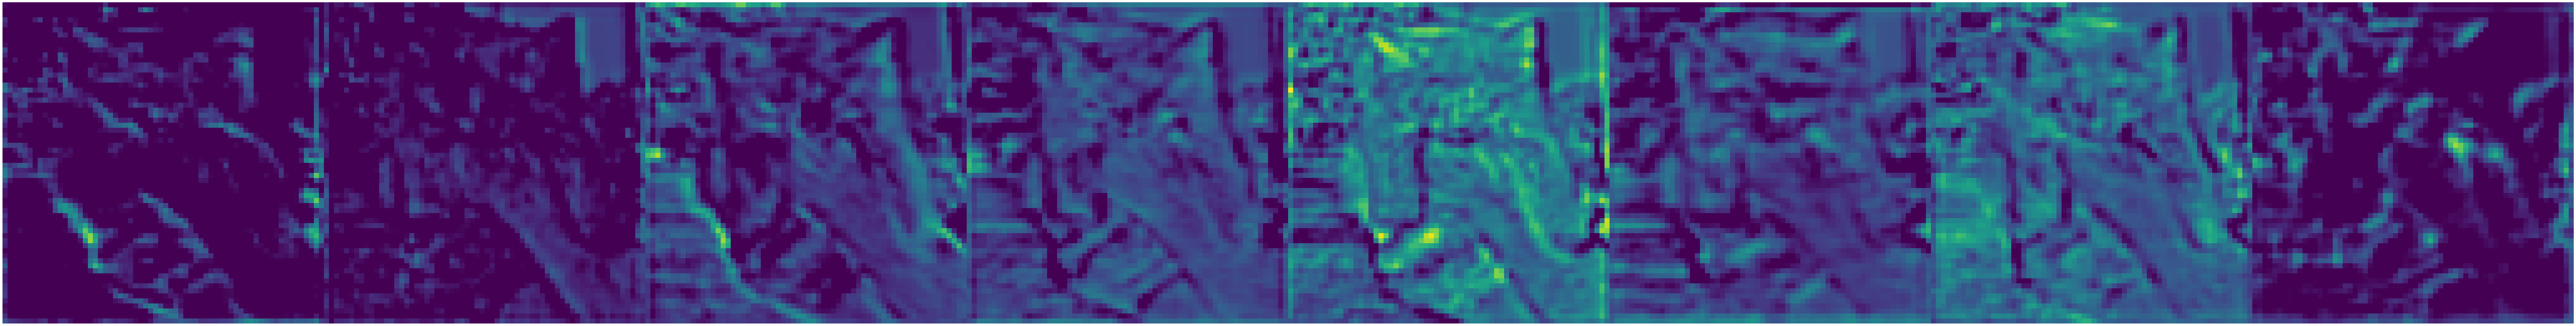

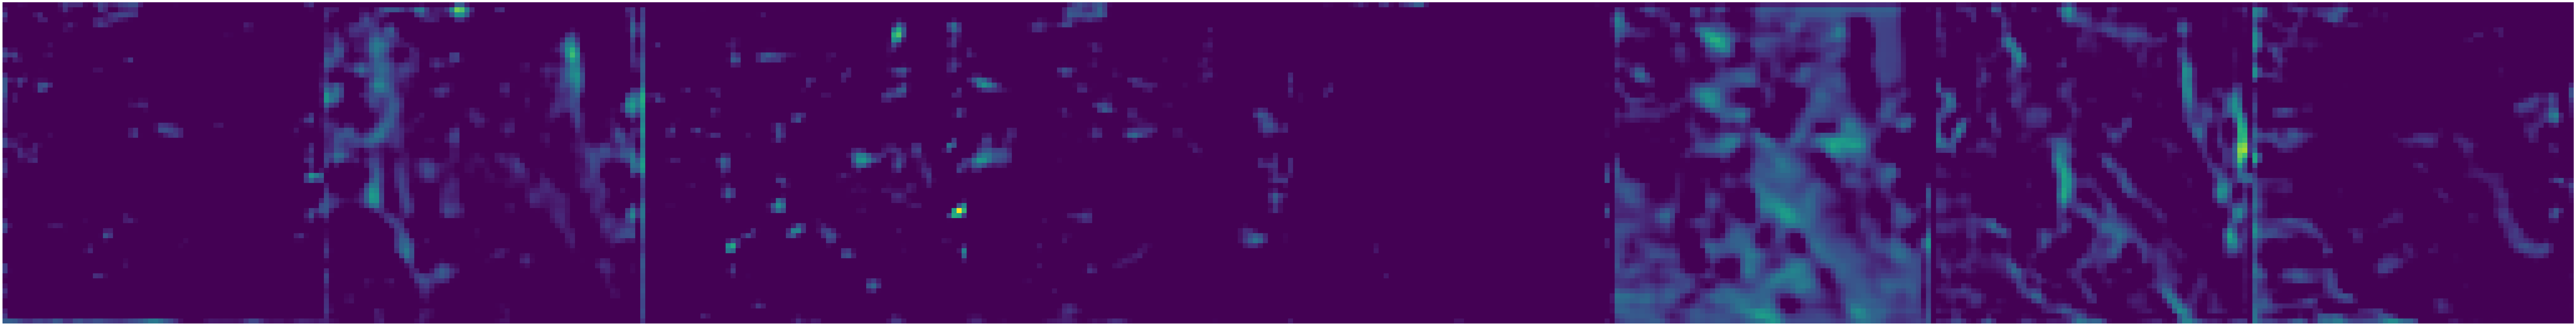

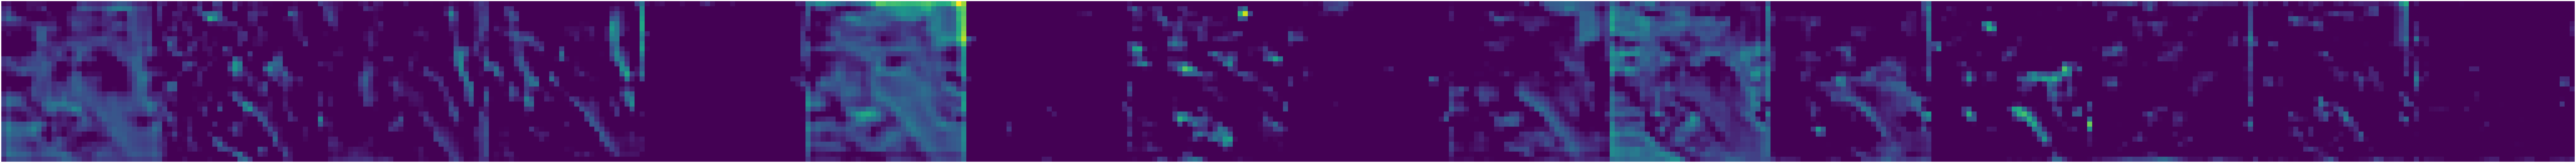

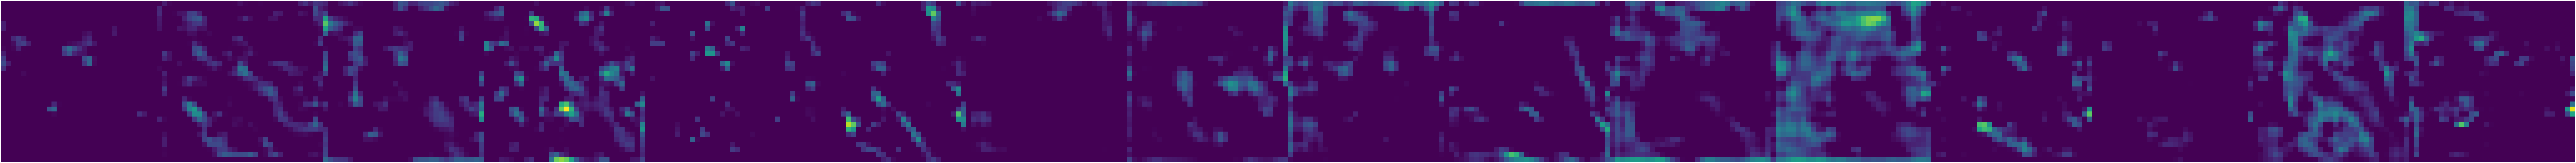

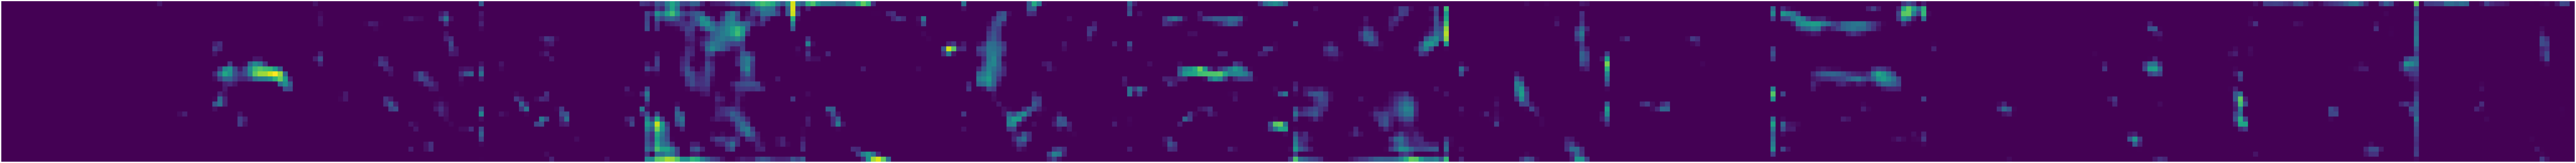

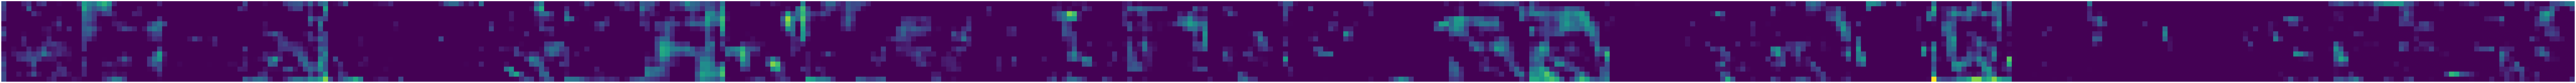

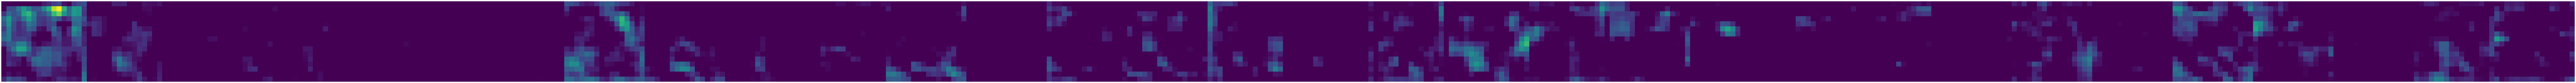

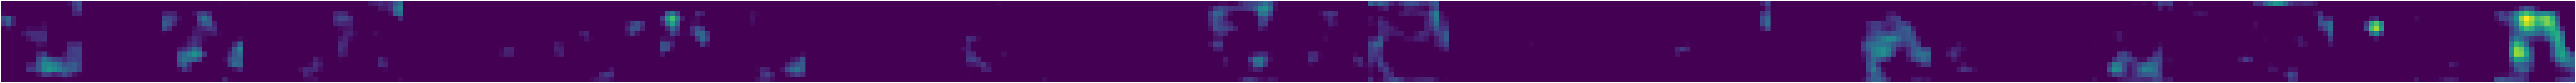

In [23]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")

In [24]:
#GradCAM

In [13]:
#we back propagate through the last convo layer kernels, calculating gradients of output wrt to feature maps
# then we get the corresponding feature maps, then obtain the mean of each feature map getting a weight scalar value
#and then muliply these weights with the real feature maps, then add these features maps and pass this to relu
#that give heat map

In [25]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [26]:
input=vgg_backbone.input
x=tf.keras.layers.Flatten()(vgg_backbone.layers[-1].output)
x=tf.keras.layers.Dense(10)(x)
output=tf.keras.layers.Dense(2, activation='softmax')(x)
model=tf.keras.Model(inputs=[input], outputs=[output])

In [27]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
)
model.fit(ds_train, epochs=3)

In [29]:
for im, label in ds_train.take(1):
  print(im.shape, label)

(1, 256, 256, 3) tf.Tensor([0], shape=(1,), dtype=int64)


In [30]:
preds=model.predict(im)

1/1 [==============================] - 2s 2s/step


In [32]:
preds, label

(array([[0.0305036 , 0.96949637]], dtype=float32),
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)

In [33]:
np.argmax(preds[0])

1

In [35]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [38]:
#now we are breaking whole trained model to two parts one that gives last conv layer feature maps
#and other that tak last conv layer feature map and do classificatn that have dense layers

In [36]:
last_conv_layer_name = "block5_pool"
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [37]:
last_conv_layer_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [39]:
classifier_layer_names = [
 "flatten_7",
 "dense_6",
 "dense_7"
]

In [40]:
classifier_input = tf.keras.Input(shape=(8,8,512))
x = classifier_input
for layer_name in classifier_layer_names:
 x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x) #output is pasing input to the specif layers of model that is for
#classificatn


In [54]:
#now we calc gradient of top class chaneel wrt last convo layer output

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(im)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index] #we want the exact score not index value of max

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(1, shape=(), dtype=int64)


In [55]:
grads.shape

TensorShape([1, 8, 8, 512])

In [56]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [63]:
pooled_grads.shape

(512,)

In [66]:
last_conv_layer_output.numpy()[0].shape

(8, 8, 512)

In [67]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(512):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [68]:
print(last_conv_layer_output.shape)

(8, 8, 512)


In [69]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

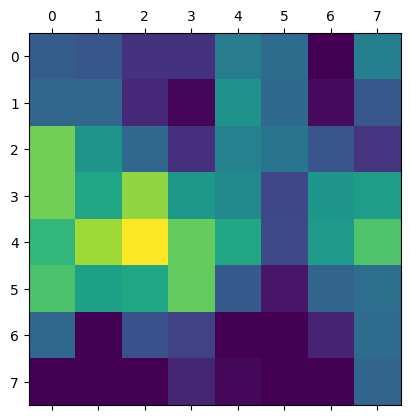

In [70]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [72]:
im.shape

TensorShape([1, 256, 256, 3])

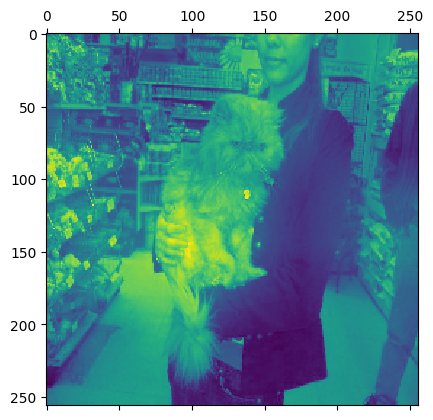

In [88]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*100+im[0,:,:,0])